# Advanced Automation 2025/26 - Assignment 1

To be delivered until 2025-12-05 23:59:59.

**Submission Notes**:
- Create a folder in your group's GitHub repository to solve this assignment. Copy this notebook into that folder.
- You should commit regularly to your repository the answers to the questions in this notebook. If you do not, your grade will be penalized by 1/20 points.
- After running the entire notebook (including graphs and outputs), save the notebook as a .pdf file, by going to File - Print - Destination: Save as PDF.
- Create a .zip file containing both the .ipynb file (the notebook itself) and the .pdf and submit it in Fénix.

# Problem description

The dataset for this assignment contains information on students from two Portuguese secondary schools enrolled in a mathematics course.
Each row corresponds to one student and includes demographic and family background variables (e.g., basic personal and household characteristics), school-related variables (e.g., school context, study habits, past failures), behavioral and lifestyle indicators (e.g., free time, going out, alcohol use), and the grades for the three school periods, on a 0–20 scale.

The goal is to predict the performance of the students in the final period.
First, the problem will be approached as a classification task, predicting whether a student will pass (G3 >= 10) or fail (G3 < 10) the course.
Then, the problem will be approached as a regression task, predicting the actual final grade (G3).

A detailed description of all variables (family context, behavioral, school performance, etc.) is provided in the file `variable_description.txt`.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

# Part 1 - Data exploration **(4.00)**

##### **1.1.** Load the dataset from the CSV file `mathematics_grades.csv`. **(0.25)**

In [13]:
df = pd.read_csv('mathematics_grades.csv')

##### **1.2.** Identify the feature types of each variable in the dataset. **(1.50)**

In [3]:
df.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
failed          bool
dtype: object

##### **1.3** Check if the dataset has missing values. If so, discard any row that has a missing value. **(0.25)**

In [4]:
df.isnull().sum()
#df = df.dropna()
#df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
failed        0
dtype: int64

##### **1.4.** Make a pairplot of the numerical variables, colored by the `failed` variable. **(0.50)**

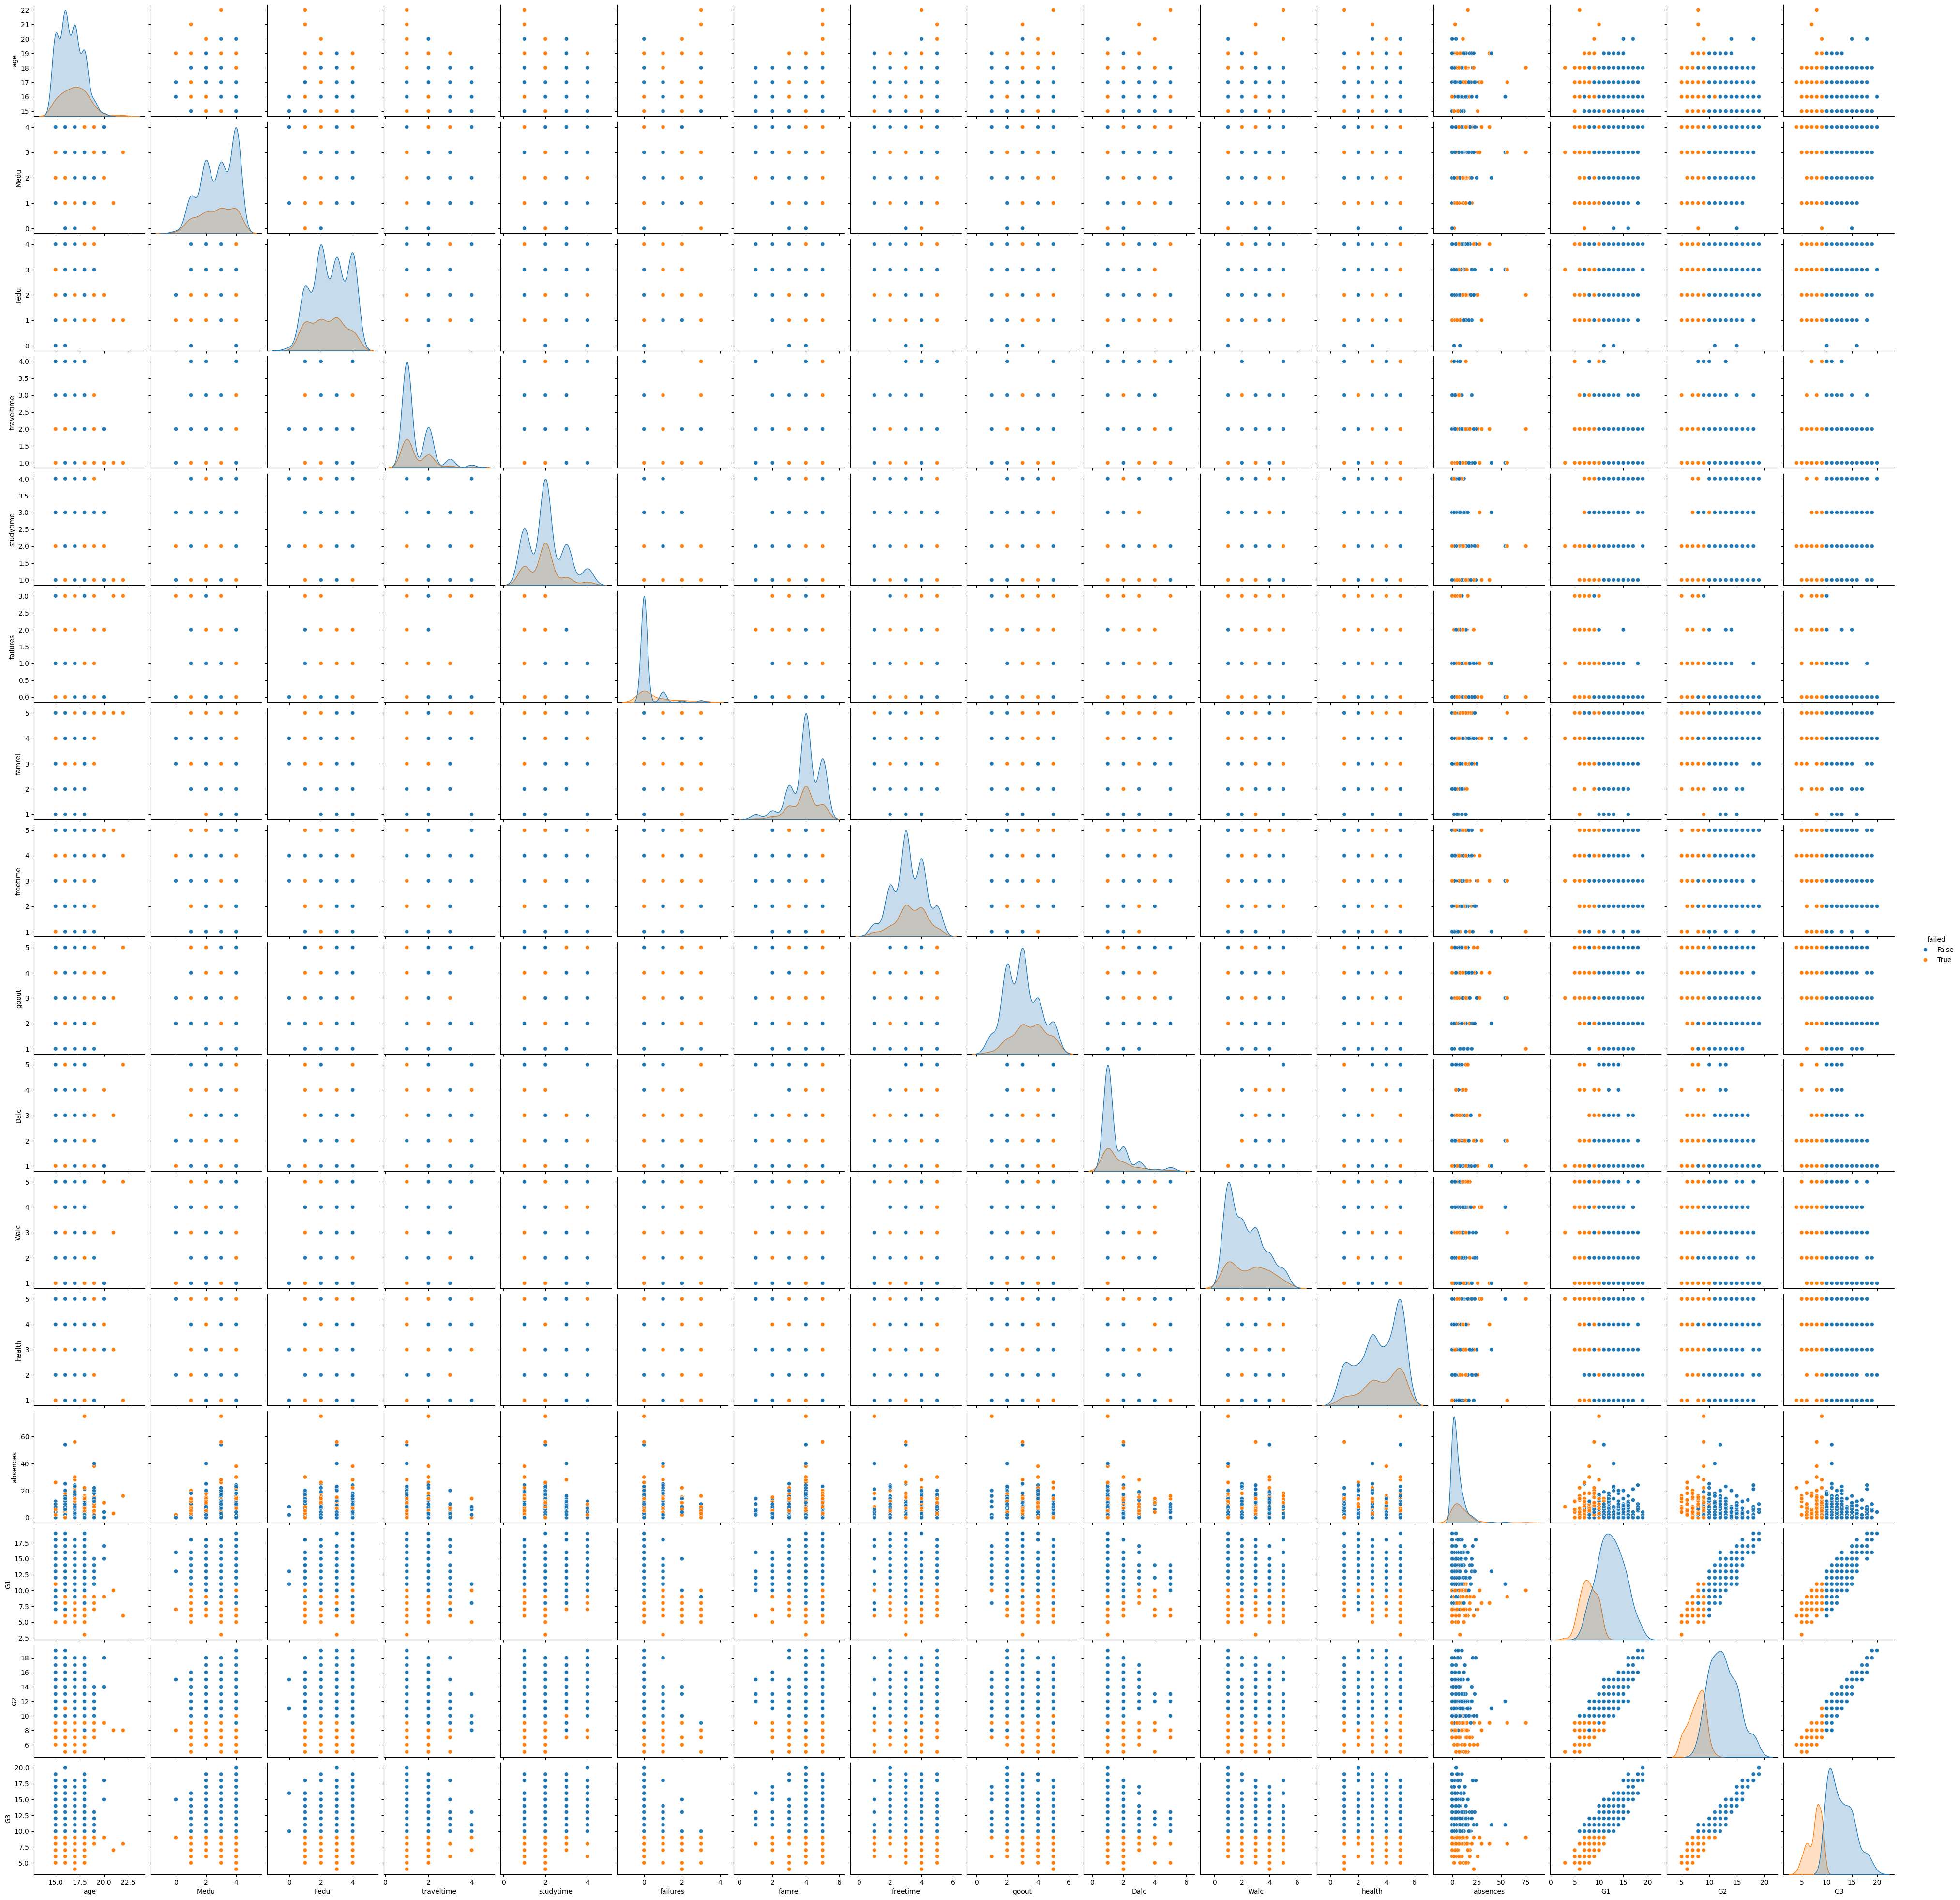

In [5]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'failed' in numerical_cols:
    plot_vars = [col for col in numerical_cols if col != 'failed']
    df['failed'] = df['failed'].astype('category')
else:
    # Se 'failed' não for numérica ou não existir, será tratado no código de erro anterior
    plot_vars = numerical_cols
sns.pairplot(df, vars=plot_vars, hue='failed', diag_kind='kde')
plt.show()

##### **1.5.** Make bar plots for each categorical variable, showing the counts for each category, colored by the `failed` variable. **(0.50)**

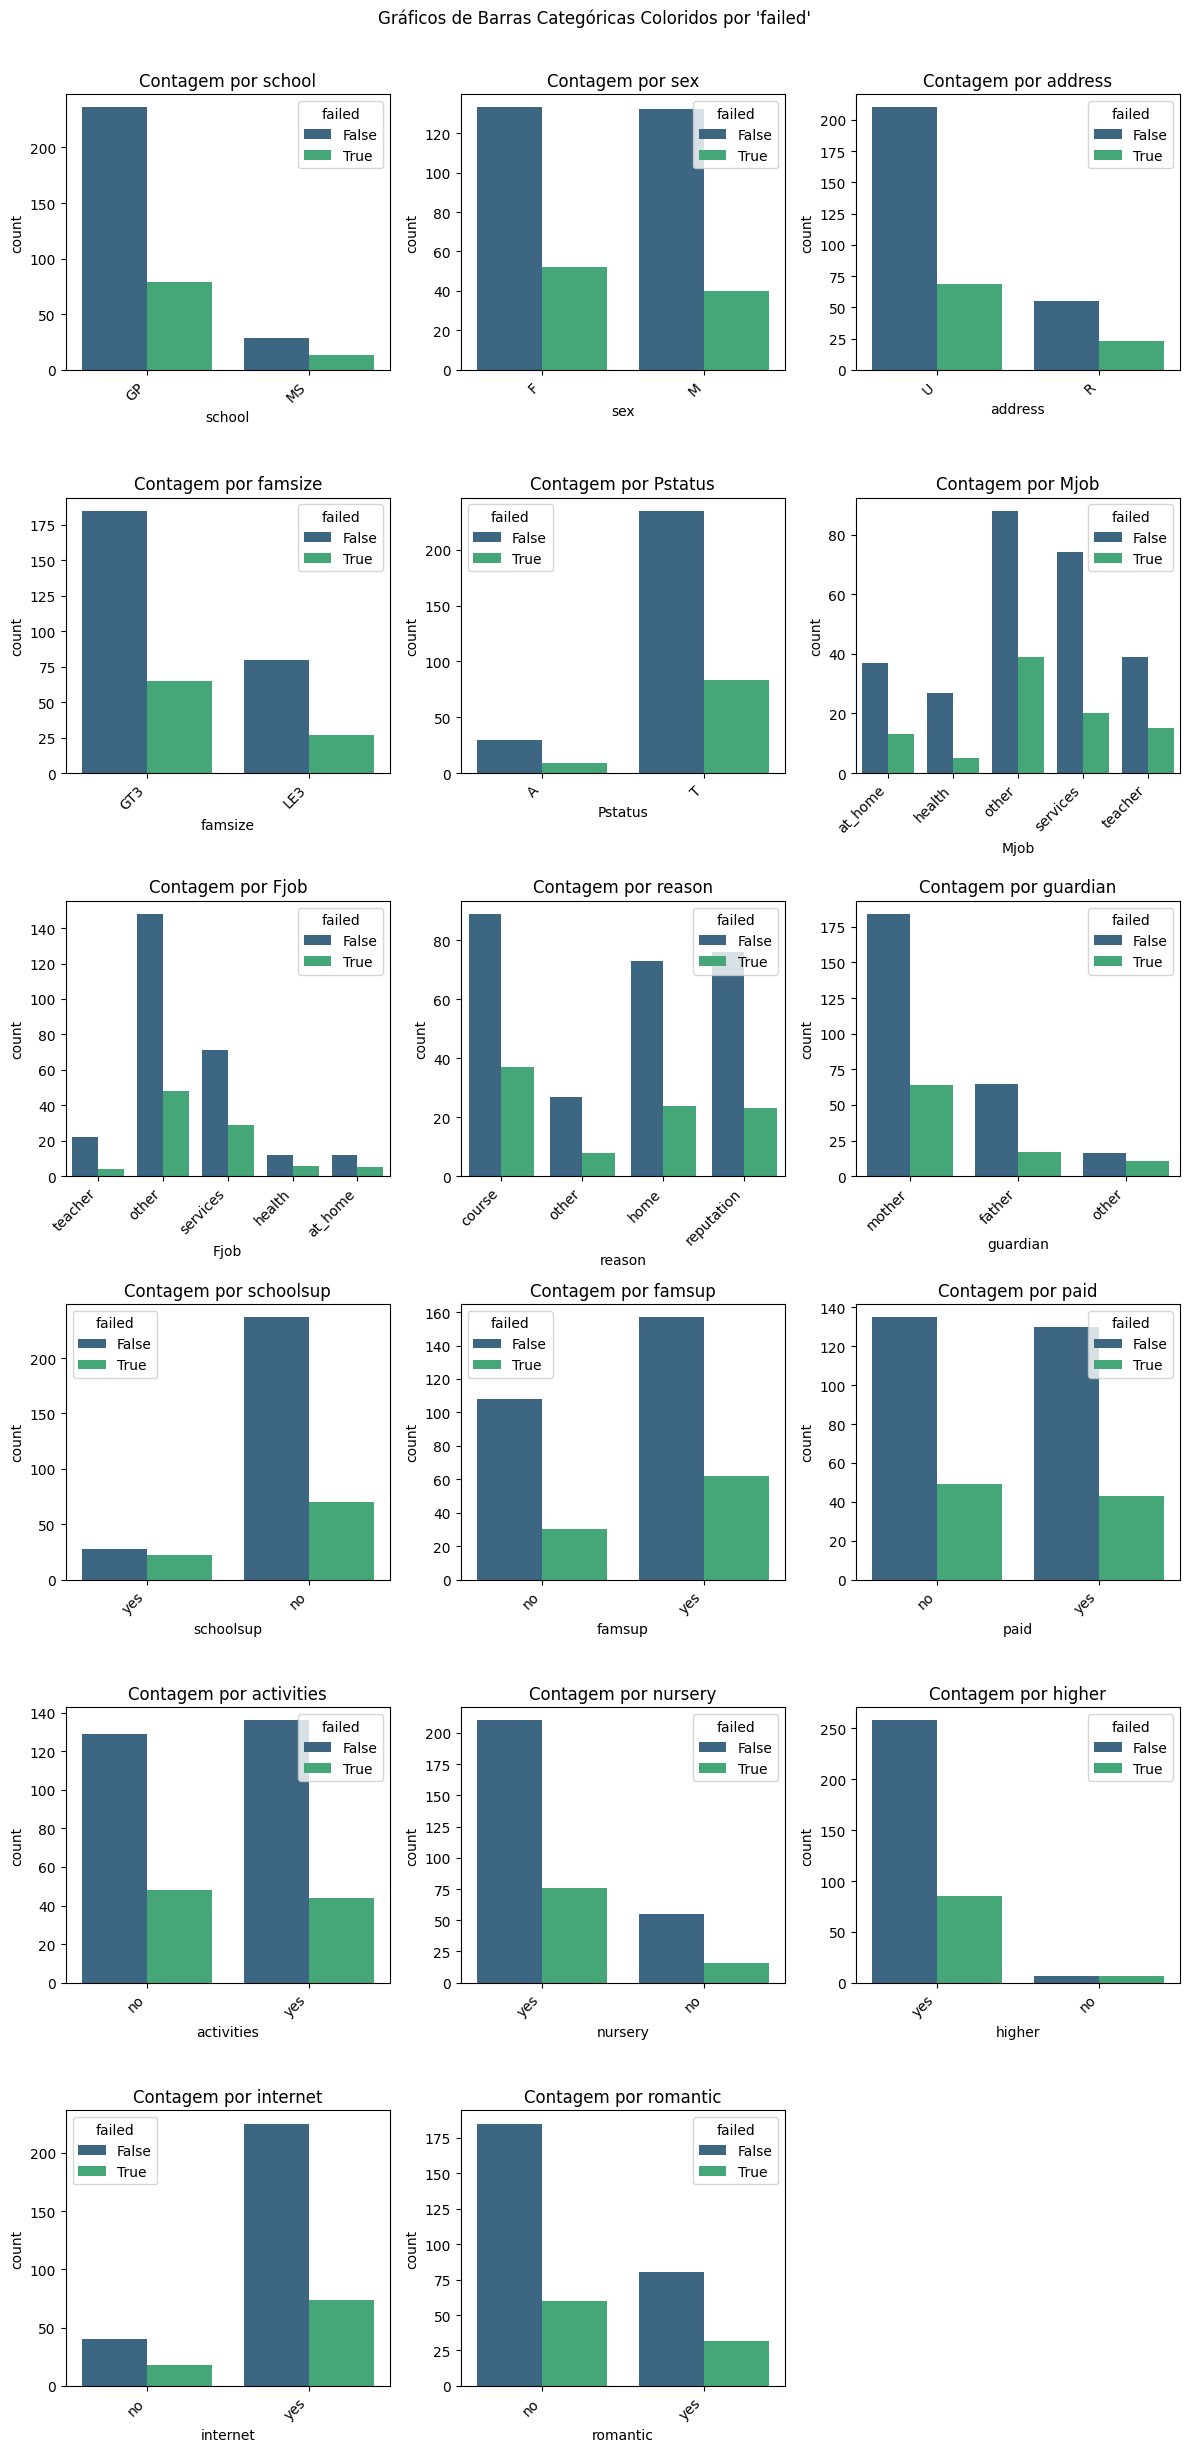

In [7]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'failed' in categorical_cols:
    categorical_cols.remove('failed')
if 'failed' in df.columns and df['failed'].dtype != 'category':
    df['failed'] = df['failed'].astype('category')
n_cols = 3 # Número de gráficos por linha
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols # Calcula o número de linhas necessárias

plt.figure(figsize=(4 * n_cols, 4 * n_rows))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(categorical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    
    sns.countplot(data=df, x=col, hue='failed', palette='viridis') 
    
    plt.title(f'Contagem por {col}')
    plt.xticks(rotation=45, ha='right') # Rotação para rótulos longos
    plt.tight_layout()

plt.suptitle("Gráficos de Barras Categóricas Coloridos por 'failed'", y=1.02)
plt.show()

##### **1.6.** In each school, how many students live in a rural area and do not have internet access at home? **(0.50)**

In [9]:
alunos_rurais_sem_net = df[
    (df['address'] == 'R') & 
    (df['internet'] == 'no')
]

contagem_por_escola = alunos_rurais_sem_net.groupby('school').size().reset_index(name='Total de Alunos Rurais Sem Net')
print(contagem_por_escola)

  school  Total de Alunos Rurais Sem Net
0     GP                              17
1     MS                               7


##### **1.7.** Split the dataset into a training set (80%) and a test set (20%). **(0.50)**

In [16]:
from sklearn.model_selection import train_test_split

X = df.drop('G3', axis=1)
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,  random_state=42)

print(f"Tamanho total do dataset original: {len(df)}")
print("-" * 40)
print(f"Tamanho do conjunto de Treino (80%): {len(X_train)} linhas")
print(f"Tamanho do conjunto de Teste (20%): {len(X_test)} linhas")

Tamanho total do dataset original: 357
----------------------------------------
Tamanho do conjunto de Treino (80%): 285 linhas
Tamanho do conjunto de Teste (20%): 72 linhas


# Part 2 - Classification **(7.50)**

##### You'll start by approaching the problem as a classification task, predicting whether a student will pass (G3 >= 10) or fail (G3 < 10) the course. Consider the variable `failed` as the target variable.

##### **2.1.** Which performance metric do you think are most important for this prediction task, and why? Justify your answer in the context of supporting students who may struggle academically. **(2.00)**

##### **2.2.** Build a logistic regression model to predict whether a student will pass or fail the course, using as predictor the feature `absences`. Evaluate the performance of the model on the test set using a confusion matrix, accuracy, precision, recall, f1-score and the metric you selected in question 2.1. **(0.50)**


--- Resultados do Modelo de Regressão Logística (Absences vs Failed) ---
Accuracy (Acurácia): 0.7222
Precision (Precisão): 0.3333
Recall (Sensibilidade): 0.0526
F1-Score: 0.0909
-----------------------------------------------------------------

Matriz de Confusão:


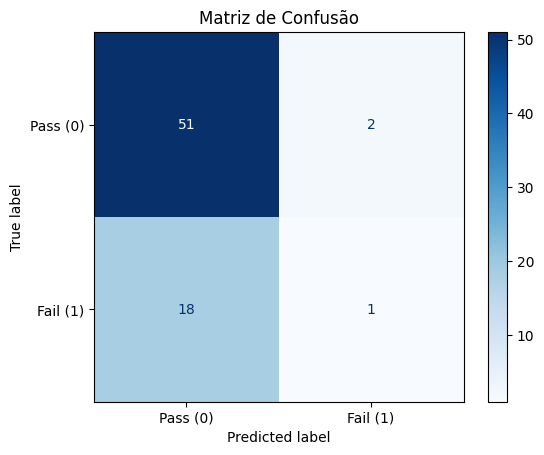


--- Análise da Matriz de Confusão ---
Verdadeiros Negativos (Passadores corretos): 51
Falsos Positivos (Passadores previstos que falharam): 2
Falsos Negativos (Falhados previstos que passaram): 18
Verdadeiros Positivos (Falhados corretos): 1


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix,
    ConfusionMatrixDisplay # Para visualização da matriz
)

df['failed'] = df['G3'].apply(lambda x: 1 if x < 10 else 0)

X = df[['absences']] 
y = df['failed']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.20, 
    random_state=42,
    stratify=y # Estratificar para garantir a mesma proporção de 'failed' no treino e teste
)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1) # Métrica selecionada
f1 = f1_score(y_test, y_pred, pos_label=1)

print("\n--- Resultados do Modelo de Regressão Logística (Absences vs Failed) ---")
print(f"Accuracy (Acurácia): {accuracy:.4f}")
print(f"Precision (Precisão): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}") # Métrica mais importante
print(f"F1-Score: {f1:.4f}")
print("-" * 65)

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

print("\nMatriz de Confusão:")
# Exibir a Matriz de Confusão de forma visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pass (0)', 'Fail (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

print("\n--- Análise da Matriz de Confusão ---")
print(f"Verdadeiros Negativos (Passadores corretos): {cm[0, 0]}")
print(f"Falsos Positivos (Passadores previstos que falharam): {cm[0, 1]}")
print(f"Falsos Negativos (Falhados previstos que passaram): {cm[1, 0]}")
print(f"Verdadeiros Positivos (Falhados corretos): {cm[1, 1]}")


##### **2.3.** The model you built in question 2.2 likely does not perform very well. Explain why this is the case, considering the distribution of the predictor and the response. How can you improve the model? **(2.00)**

##### **2.4.** Consider now the variable `studytime` as the predictor and assume it is numerical. Build a logistic regression model to predict whether a student will pass or fail the course. Evaluate the performance of the model on the test set using a confusion matrix, accuracy, precision, recall, f1-score and the metric you selected in question 2.1. **(0.50)**

Note: Use `sklearn.linear_model.LogisticRegression(class_weight='balanced')` for your logistic regression model.

##### **2.5.** Repeat question 2.4, but now considering `studytime` as a categorical variable. **(0.50)**

##### **2.6.** What is the difference between the two models you built in questions 2.4 and 2.5? Plot the predictions of each model over the range of `studytime` values in the test set. What are the advantages and disadvantages of each approach? **(2.00)**


# Part 3 - Regression (3.50)

##### In this part of the assignment, you'll approach the problem as a regression task, predicting the actual final grade `G3`. Use the same training and test sets you created in Part 1.

##### **3.1.** Build a linear regression model to predict the final grade `G3`, using as predictor the feature `G2`. Evaluate the performance of the model on the test set using Mean Squared Error (MSE) and R-squared ($R^2$). **(0.50)**

##### **3.2.** Print the equation of the model you built in question 3.1. Plot the predictions of the model as a function of the inputs, along with the actual data points from the test set. Interpret the coefficients of the model. **(1.00)**


##### **3.3.** Build a linear regression model to predict the final grade `G3`, using as predictors all features except the variables related to the grades (`G1`, `G2`, `G3`, `failed`). Explain the choices you made. Evaluate the performance of the model on the test set using Mean Squared Error (MSE) and R-squared ($R^2$). Plot the predicted vs actual values of `G3` for the test set. **(1.00)**

##### **3.4.** In terms of application, what is the difference between building a model to predict student performance using the grades of the previous periods (as in question 3.1) versus using other features (as in question 3.3)? When would each approach be more appropriate? **(1.00)**

# Part 4 - Cross-validation (4.00)

##### **4.1.** Explain the concept of cross-validation and its importance in evaluating machine learning models. **(1.00)**

##### **4.2.** Describe how K-fold cross-validation works. What values of K should be used? Justify. **(1.00)**

##### **4.3.** Explain how K-Fold cross-validation should be done to choose the classification threshold for the logistic regression model of Part 2. **(2.00)**

# Part 5 - GitHub (1.00)

##### **5.1.** Describe how your group used GitHub to track changes throughout the project and explain why maintaining a clear change history is important in data analysis and machine learning work. **(1.00)**